#Loading Dataset and libraries

In [ ]:
!pip install unrar
!unrar x /content/drive/MyDrive/Covid_mrinal/CovidXRay.rar

Streaming output truncated to the last 5000 lines.
Extracting  Chest X-Ray image dataset/Normal/Normal-6710.png              75%  OK 
Extracting  Chest X-Ray image dataset/Normal/Normal-6711.png              75%  OK 
Extracting  Chest X-Ray image dataset/Normal/Normal-6712.png              75%  OK 
Extracting  Chest X-Ray image dataset/Normal/Normal-6713.png              75%  OK 
Extracting  Chest X-Ray image dataset/Normal/Normal-6714.png              75%  OK 
Extracting  Chest X-Ray image dataset/Normal/Normal-6715.png              75%  OK 
Extracting  Chest X-Ray image dataset/Normal/Normal-6716.png              75%  OK 
Extracting  Chest X-Ray image dataset/Normal/Normal-6717.png              75%  OK 
Extracting  Chest X-Ray image dataset/Normal/Normal-6718.png              75%  OK 
Extracting  Chest X-Ray image dataset/Normal/Normal-6719.png              75%  OK 
Extracting  Chest X-Ray image

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import os
from matplotlib.pyplot import imread
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
import cv2
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

In [ ]:
images = []
classes_labels = []
for i in os.listdir("/content/dataset"):
  class_path = f"/content/dataset/{i}"
  for j in os.listdir(class_path):
    file_path = f"{class_path}/{j}"
    classes_labels.append(i)
    images.append(cv2.resize(cv2.imread(file_path, 1), (224, 224)))

In [ ]:
lb = LabelBinarizer()
classes_labels = lb.fit_transform(classes_labels)

In [ ]:
train_images, test_images, train_labels, test_labels = train_test_split(images, classes_labels, test_size = 0.2, random_state = 42)

#Dataset Description

In [ ]:
#Complete Dataset Description
items = set(classes_labels)
for i in items:
  print(f"{lb.classes_[i]} : {list(classes_labels).count(i)}")

In [ ]:
#Training Set Description
items = set(train_labels)
for i in items:
  print(f"{lb.classes_[i]} : {list(train_labels).count(i)}")

In [ ]:
#Test Set Description
items = set(test_labels)
for i in items:
  print(f"{lb.classes_[i]} : {list(test_labels).count(i)}")

#Data Generation and augmentation

In [ ]:
train_generator = ImageDataGenerator(rotation_range=5, horizontal_flip=True, zoom_range=0.15, width_shift_range=20, height_shift_range=20, validation_split=0.2)

In [ ]:
test_generator = ImageDataGenerator()

In [ ]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [ ]:
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [ ]:
train = train_generator.flow(x=train_images, y=train_labels, seed=42, shuffle=True, subset="training")

In [ ]:
validation = train_generator.flow(x=train_images, y=train_labels, seed=42, shuffle=True, subset="validation")

In [ ]:
test = test_generator.flow(x=test_images, y=test_labels, seed=42, shuffle=True)

In [ ]:
labels = [np.argmax(x) for x in train_labels]

In [ ]:
class_weights = class_weight.compute_class_weight(class_weight="balanced", classes=[0, 1, 2, 3], y=labels)

In [ ]:
model_class_weights = {x : y for x, y in enumerate(class_weights)}

#Data Visualization Methods

In [ ]:
def data(history):
  return pd.DataFrame(data=list(zip(history.history["accuracy"], history.history["val_accuracy"], history.history["loss"], history.history["val_loss"], history.history["recall"], history.history["val_recall"], history.history["precision"], history.history["val_precision"], history.history["auc"], history.history["val_auc"], history.history["specificity"], history.history["val_specificity"], history.history["sensitivity"], history.history["val_sensitivity"], history.history["mcc"], history.history["val_mcc"])) , columns=["Accuracy", "Validation Accuracy", "Loss", "Validation Loss", "Recall", "Validation Recall", "Precision", "Validation Precision", "AUC", "Validation AUC", "Specificity", "Validation Specificity" ,"Sensitivity", "Validation Sensitivity", "MCC", "Validation MCC"])

In [ ]:
def history_visualization(df):
  sns.set_style('darkgrid')
  nrow = 4
  ncol = 2
  df_columns = df.columns
  df_list = [df[col] for col in df]
  titles=["Accuracy Visualization", "Loss Visualization", "Recall Visualization", "Precision Visualization", "AUC Visualization", "Specificity Visualization", "Sensitivity Visualization", "MCC Visualization"]
  fig, axes = plt.subplots(nrow, ncol, figsize=(20, 16))
  count = 0
  i = 0
  for r in range(nrow):
    for c in range(ncol):
        df_list[count].plot(ax=axes[r,c], x="Number of Epochs", legend="brief", label=df_columns[count], marker="o").set_title(titles[i])
        df_list[count+1].plot(ax=axes[r, c], x="Number of Epochs", legend="brief" ,label=df_columns[count+1], marker="o").set_title(titles[i])
        i+=1
        count+=2

In [ ]:
early_stoping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)

#Custom Metrics using tensorflow

In [ ]:
def true_positive(y_true, y_pred):
  y_true = tf.argmax(y_true)
  y_pred = tf.argmax(y_pred)
  res = tf.math.confusion_matrix(y_true, y_pred, dtype=tf.float32)
  return tf.reduce_sum(tf.linalg.diag_part(res), axis = 0)

def false_positive(y_true, y_pred):
  y_true = tf.argmax(y_true)
  y_pred = tf.argmax(y_pred)
  res = tf.math.confusion_matrix(y_true, y_pred, dtype=tf.float32)
  return tf.reduce_sum(tf.reduce_sum(res, axis = 1) - tf.linalg.diag_part(res), axis = 0)

def false_negative(y_true, y_pred):
  y_true = tf.argmax(y_true)
  y_pred = tf.argmax(y_pred)
  res = tf.math.confusion_matrix(y_true, y_pred, dtype=tf.float32)
  return tf.reduce_sum(tf.reduce_sum(res, axis = 1) - tf.linalg.diag_part(res), axis = 0)

def true_negative(y_true, y_pred):
  y_true_res = tf.argmax(y_true)
  y_pred_res = tf.argmax(y_pred)
  res = tf.math.confusion_matrix(y_true_res, y_pred_res, dtype=tf.float32)
  return tf.reduce_sum(tf.reduce_sum(res, axis = 1), axis=0) - (false_negative(y_true, y_pred) + false_positive(y_true, y_pred) + true_positive(y_true, y_pred))

In [ ]:
def sensitivity(y_true, y_pred):
    y_actual = tf.argmax(y_true).numpy()
    y_hat = tf.argmax(y_pred).numpy()
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1
    num = float(TP)
    den = float(TP + FN)
    if den == 0.0:
      return tf.constant(0.0, dtype=tf.float32)
    return tf.constant(float(num/den), dtype=tf.float32)

def specificity(y_true, y_pred):
    y_actual = tf.argmax(y_true).numpy()
    y_hat = tf.argmax(y_pred).numpy()
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1
    num = float(TN)
    den = float(TN + FP)
    if den == 0.0:
      return tf.constant(0.0, dtype=tf.float32)
    return tf.constant(float(num/den), dtype=tf.float32)

In [ ]:
def mcc(y_true, y_pred):
  y_true = tf.argmax(y_true).numpy()
  y_pred = tf.argmax(y_pred).numpy()

  return tf.constant(matthews_corrcoef(y_true, y_pred))

#VGG19 without class weights

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
base_model_resnet50 = VGG19(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
base_model_resnet50.trainable = False
base_model_resnet50.summary()
final_model_resnet50 = keras.models.Sequential([base_model_resnet50, keras.layers.Flatten(), keras.layers.Dense(4, activation="softmax")])
final_model_resnet50.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[keras.metrics.Accuracy(), keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC(), specificity, sensitivity, mcc], run_eagerly=True)
resnet50_history = final_model_resnet50.fit(train, validation_data=validation, epochs = 25, batch_size=32, callbacks=[early_stoping])

80150528/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
df = data(resnet50_history)

In [ ]:
df

,Accuracy,Validation Accuracy,Loss,Validation Loss,Recall,Validation Recall,Precision,Validation Precision,AUC,Validation AUC,Specificity,Validation Specificity,Sensitivity,Validation Sensitivity,MCC,Validation MCC
0,0.445870,0.545851,5.285218,4.441497,0.780156,0.822209,0.780329,0.822209,0.873566,0.897928,0.613208,0.660377,0.397406,0.415094,0.550717,0.669182
1,0.611177,0.671589,5.264777,5.305875,0.826443,0.841110,0.826504,0.841110,0.898358,0.906342,0.747642,0.789308,0.449292,0.429245,0.661761,0.703316
2,0.671305,0.699424,5.136264,5.837053,0.838993,0.846426,0.839303,0.846426,0.905407,0.906167,0.738601,0.750000,0.477594,0.526730,0.686572,0.696366
3,0.716355,0.698317,5.026525,5.652054,0.857449,0.842882,0.857449,0.842882,0.915058,0.904406,0.787736,0.789308,0.458726,0.481132,0.707326,0.720454
4,0.729533,0.735012,5.017025,6.632873,0.859959,0.834613,0.859959,0.834613,0.916627,0.899366,0.753931,0.702830,0.500000,0.457547,0.725184,0.690887
5,0.756644,0.762109,5.162573,6.359388,0.862985,0.861784,0.863177,0.861784,0.918998,0.916195,0.777516,0.740566,0.503538,0.481132,0.741195,0.653062
6,0.764709,0.769344,5.016195,6.385357,0.871475,0.861488,0.871539,0.861488,0.923318,0.915867,0.793239,0.844340,0.482311,0.490566,0.745449,0.749664
7,0.776244,0.785735,4.734101,6.525446,0.879595,0.862374,0.879595,0.862374,0.928483,0.913957,0.838443,0.768868,0.484670,0.400943,0.762859,0.733669
8,0.791451,0.770673,5.121781,7.434483,0.875240,0.841996,0.875240,0.841996,0.925087,0.901636,0.817217,0.822327,0.487028,0.514151,0.760204,0.711717


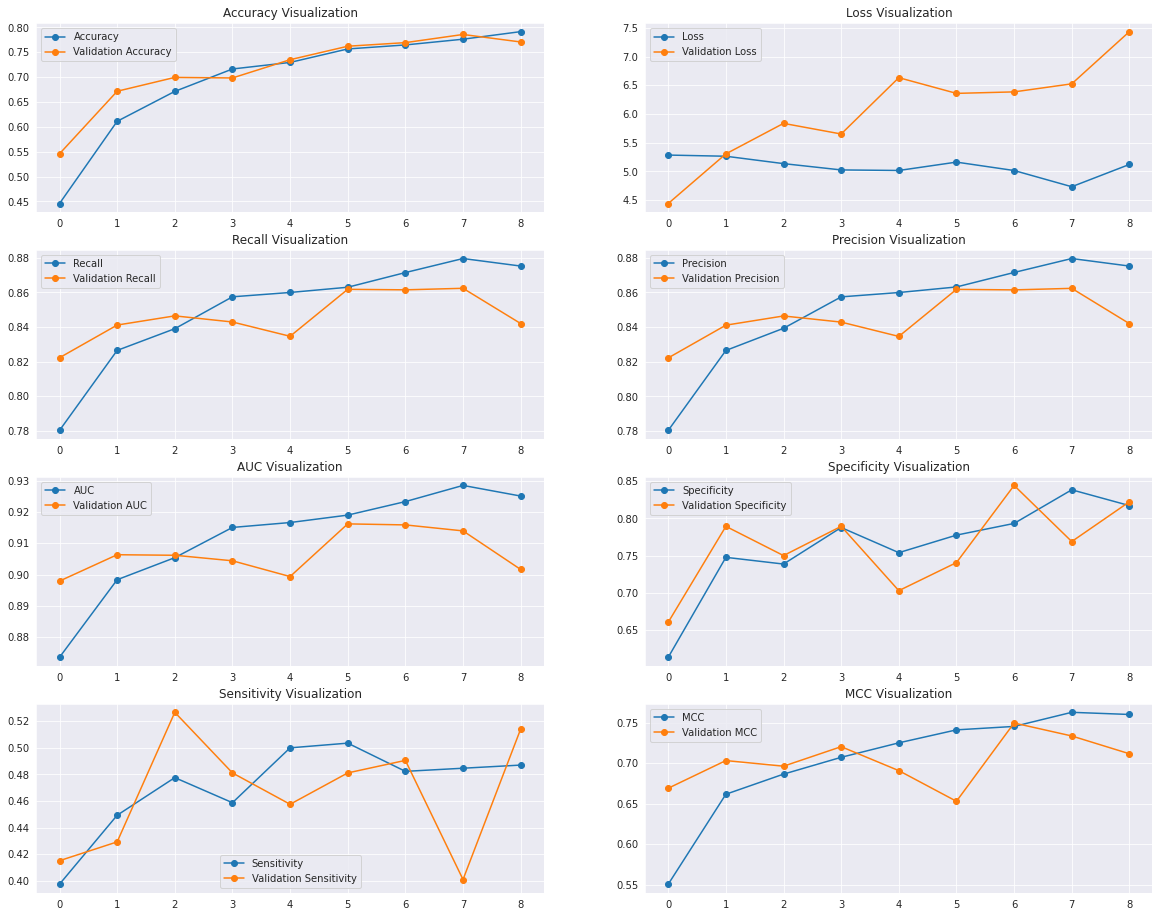

In [ ]:
history_visualization(df)

In [ ]:
test_predictions = final_model_resnet50.predict(test_images)
test_predictions_inverse = lb.inverse_transform(test_predictions)

In [ ]:
test_labels_inverse = lb.inverse_transform(test_labels)

In [ ]:
print(classification_report(test_labels_inverse, test_predictions_inverse))

                 precision    recall  f1-score   support

          COVID       0.87      0.75      0.81       737
   Lung opacity       0.84      0.80      0.82      1175
         Normal       0.85      0.93      0.89      2088
Viral Pneumonia       0.98      0.80      0.88       233

       accuracy                           0.86      4233
      macro avg       0.89      0.82      0.85      4233
   weighted avg       0.86      0.86      0.86      4233



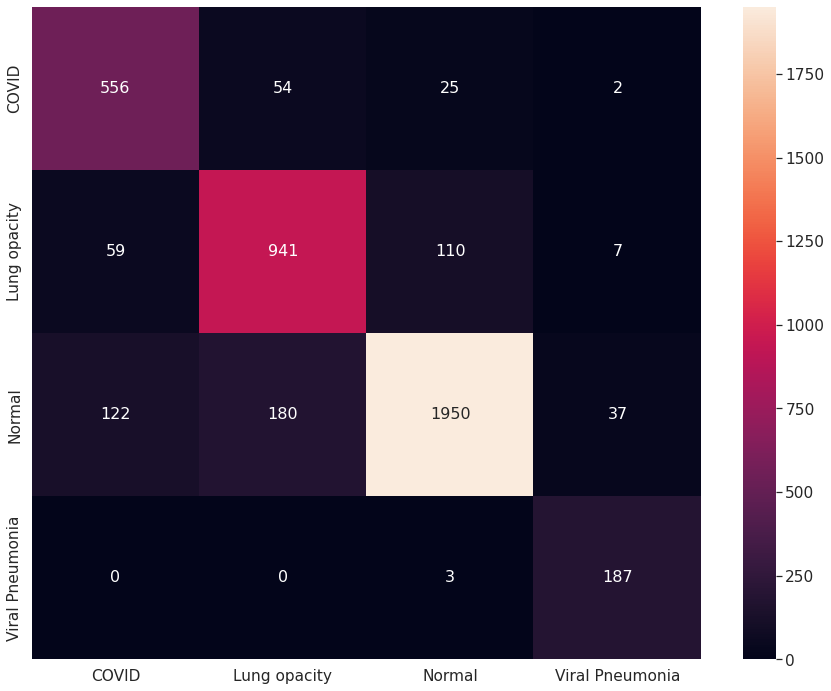

In [ ]:
plt.figure(figsize=(15, 12))
cm = confusion_matrix(test_predictions_inverse, test_labels_inverse)
df_cm = pd.DataFrame(cm, index = [i for i in lb.classes_],
                  columns = [i for i in lb.classes_])
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') 
plt.show()

#VGG19 with class weights

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
base_model_resnet50 = VGG19(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
base_model_resnet50.trainable = False
base_model_resnet50.summary()
final_model_resnet50 = keras.models.Sequential([base_model_resnet50, keras.layers.Flatten(), keras.layers.Dense(4, activation="softmax")])
final_model_resnet50.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[keras.metrics.Accuracy(), keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC(), specificity, sensitivity, mcc], run_eagerly=True)
resnet50_history = final_model_resnet50.fit(train, validation_data=validation, epochs = 25, batch_size=32, callbacks=[early_stoping], class_weight=model_class_weights)

80150528/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
final_model_resnet50.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 4)                 100356    
                                                                 
Total params: 20,124,740
Trainable params: 100,356
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
df = data(resnet50_history)

In [ ]:
df

,Accuracy,Validation Accuracy,Loss,Validation Loss,Recall,Validation Recall,Precision,Validation Precision,AUC,Validation AUC,Specificity,Validation Specificity,Sensitivity,Validation Sensitivity,MCC,Validation MCC
0,0.435073,0.538763,5.541771,7.436491,0.746493,0.778795,0.746604,0.779025,0.852406,0.866465,0.544811,0.632075,0.358491,0.382075,0.504340,0.603931
1,0.595102,0.605360,4.931984,11.201448,0.808800,0.717956,0.808859,0.718381,0.887925,0.824305,0.714623,0.589623,0.444575,0.344340,0.625218,0.561803
2,0.654880,0.642868,4.803687,6.567634,0.823195,0.804489,0.823256,0.804489,0.894779,0.884039,0.727987,0.721698,0.474057,0.471698,0.681800,0.654738
3,0.683541,0.684214,5.651270,8.735061,0.823047,0.778204,0.823169,0.778434,0.893547,0.863926,0.722877,0.694969,0.436321,0.419811,0.670102,0.654638
4,0.730474,0.700089,5.769763,8.957859,0.833973,0.795334,0.834035,0.795334,0.899602,0.875747,0.743318,0.674528,0.472877,0.419811,0.711962,0.643035
5,0.741916,0.709096,4.645842,9.068542,0.851026,0.798582,0.851089,0.798582,0.910049,0.875355,0.772013,0.732704,0.482311,0.457547,0.725729,0.642885
6,0.760169,0.781675,4.650066,7.093268,0.855455,0.850856,0.855455,0.850856,0.912462,0.909836,0.747642,0.787736,0.479953,0.495283,0.722079,0.714676
7,0.767219,0.724306,4.619204,9.319658,0.861140,0.792380,0.861140,0.792380,0.916027,0.868994,0.782233,0.685535,0.511792,0.353774,0.746515,0.647834
8,0.773162,0.729400,4.908538,12.783296,0.856415,0.802126,0.856415,0.802126,0.913152,0.876412,0.767296,0.646226,0.470519,0.476415,0.716376,0.602062
9,0.786118,0.814604,4.659451,7.695227,0.864388,0.865032,0.864388,0.865032,0.918027,0.913432,0.795597,0.841195,0.491745,0.476415,0.756484,0.748138


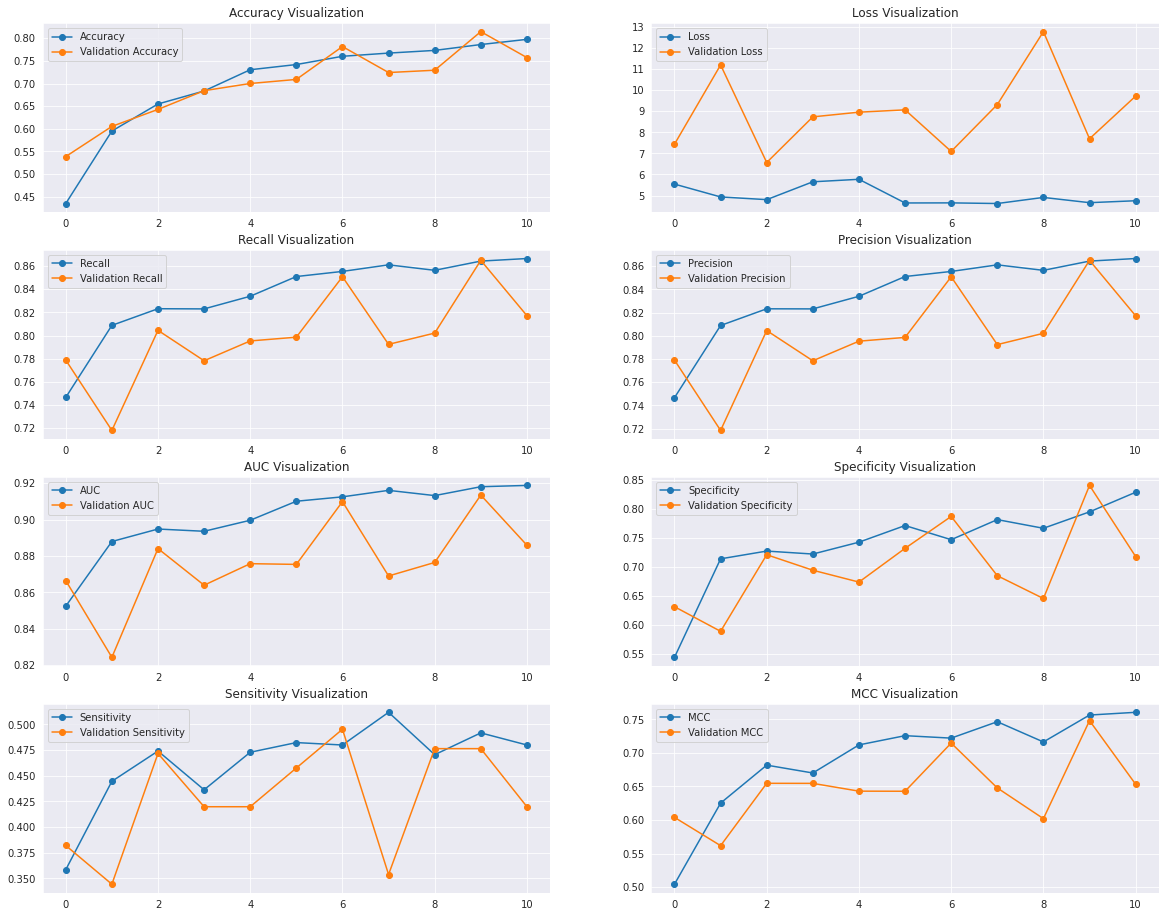

In [ ]:
history_visualization(df)

In [ ]:
final_model_resnet50.save("/content/drive/MyDrive/COVID/final_model_resnet50_with_class_weights_3_classes.h5")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
test_predictions = final_model_resnet50.predict(test_images)
test_predictions_inverse = lb.inverse_transform(test_predictions)

In [ ]:
test_labels_inverse = lb.inverse_transform(test_labels)

In [ ]:
print(classification_report(test_labels_inverse, test_predictions_inverse))

                 precision    recall  f1-score   support

          COVID       0.77      0.91      0.83       737
   Lung opacity       0.83      0.82      0.82      1175
         Normal       0.92      0.88      0.90      2088
Viral Pneumonia       0.98      0.82      0.89       233

       accuracy                           0.86      4233
      macro avg       0.87      0.86      0.86      4233
   weighted avg       0.87      0.86      0.87      4233



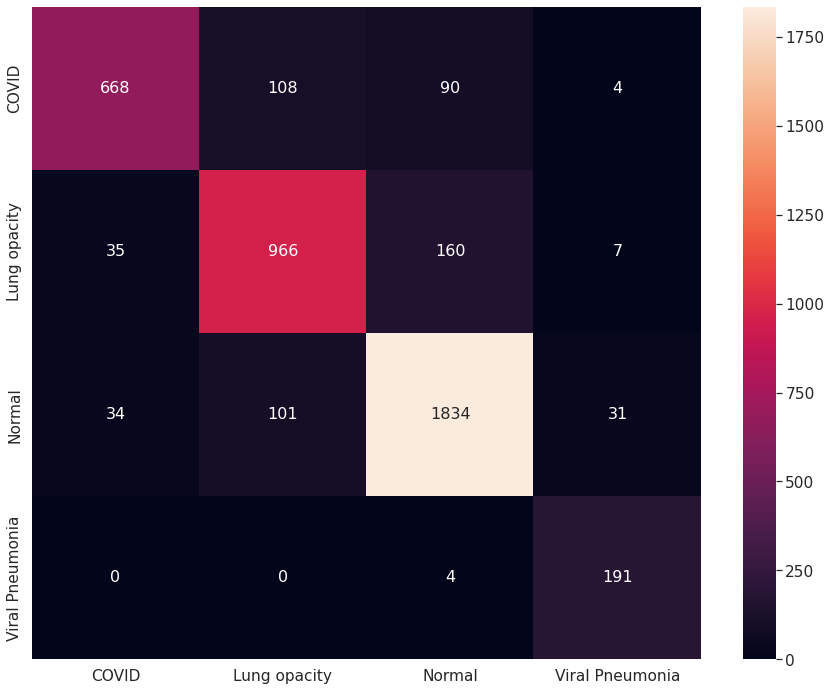

In [ ]:
plt.figure(figsize=(15, 12))
cm = confusion_matrix(test_predictions_inverse, test_labels_inverse)
df_cm = pd.DataFrame(cm, index = [i for i in lb.classes_],
                  columns = [i for i in lb.classes_])
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') 
plt.show()